In [16]:
class CustomDataset(Dataset):
    def __init__(self, root, train=True, val=False, transform=None):
        self.root = root
        self.transform = transform
        self.images = []
        self.labels = []

        # Load images and labels from your dataset
        if train:
            folder = os.path.join(root, 'train')
        elif val:
            folder = os.path.join(root, 'val')
        else:
            folder = os.path.join(root, 'test')

        for class_folder in os.listdir(folder):
            class_folder_path = os.path.join(folder, class_folder)
            for filename in os.listdir(class_folder_path):
                img_path = os.path.join(class_folder_path, filename)
                label = 0 if class_folder == 'clear' else 1
                self.images.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)

        return img, label

In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import torch.nn.functional as F

In [18]:
# Define the data loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [31]:
test_dataset = CustomDataset(root='..\\..\\AI_generated_Data\\', train=False, val=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [20]:
import torch

def adjust_weights_based_on_f1(model1_f1, model2_f1):
    # Calculate inverses of F1 scores
    inverse_model1_f1 = 1 / model1_f1
    inverse_model2_f1 = 1 / model2_f1
    
    # Normalize inverses
    total_inverse = inverse_model1_f1 + inverse_model2_f1
    weight_model1 = inverse_model1_f1 / total_inverse
    weight_model2 = inverse_model2_f1 / total_inverse
    
    return weight_model1, weight_model2

def ensemble_predict(model1, model2, dataloader, model1_f1=None, model2_f1=None):
    ens_predictions = []
    true_label = []
    model1_predictions = []
    model2_predictions = []
    weights = None
    
    # Adjust weights based on F1 scores if provided
    if model1_f1 is not None and model2_f1 is not None:
        weights = adjust_weights_based_on_f1(model1_f1, model2_f1)
    elif weights is None:
        weights = [0.5, 0.5]  # Default weights if not provided
    
    for inputs, labels in dataloader:        
        outputs1 = model1(inputs)
        outputs2 = model2(inputs)
        
        # Weighted averaging
        weighted_outputs = (outputs1 * weights[0]) + (outputs2 * weights[1])
        
        ens_predictions.extend(torch.max(weighted_outputs, 1)[1].tolist())
        true_label.extend(labels.tolist())
        model1_predictions.extend(torch.max(outputs1, 1)[1].tolist())
        model2_predictions.extend(torch.max(outputs2, 1)[1].tolist())
        
    return {
        'ensemble_pred': ens_predictions,
        'label': true_label,
        '1_pred': model1_predictions,
        '2_pred': model2_predictions
    }


c:\Users\rdede\Documents\GitHub\SnowDetection\.env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rdede\Documents\GitHub\SnowDetection\.env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


True values: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Ensemble predictions: [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 

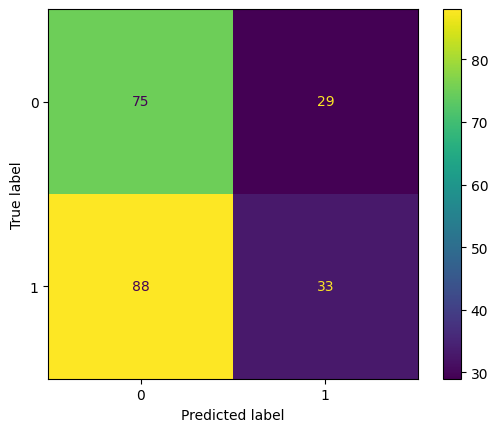

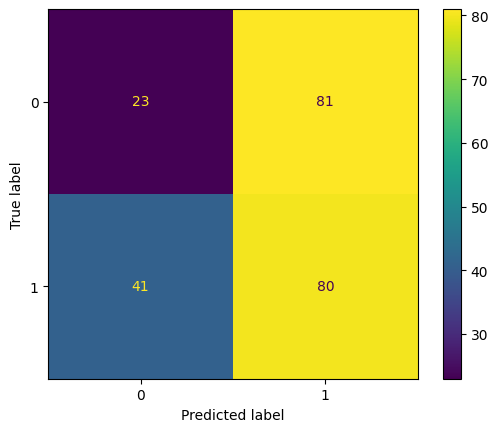

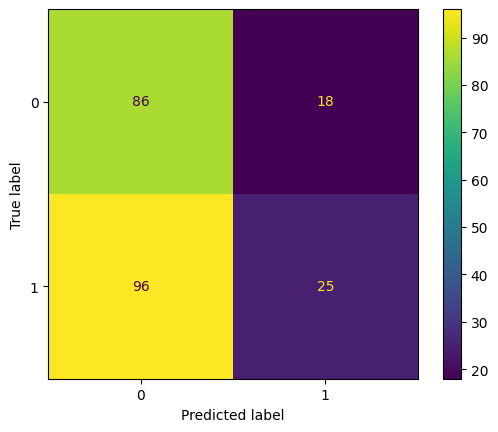

In [33]:
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score


# Load the saved models
vgg19_path = '../../models/02-25-2024/lr_0.0001/vgg19_epoch_15.pt'  # Adjust the path as per your saved model
resnet50_path = '../../models/02-25-2024/lr_0.0001/resnet50_epoch_15.pt'  # Adjust the path as per your saved model

# Define the VGG-19 model architecture
vgg19_model = models.vgg19(pretrained=False)

# Modify the classifier layer for 2 classes
vgg19_model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)

# Load the parameters into the model
state_dict = torch.load(vgg19_path)
# Remove classifier parameters from the loaded state dict
for key in list(state_dict.keys()):
    if 'classifier' in key:
        del state_dict[key]
vgg19_model.load_state_dict(state_dict, strict=False)

# Ensure the model is in evaluation mode
vgg19_model.eval()


# Define the ResNet-50 model architecture
resnet50_model = models.resnet50(pretrained=False)

# Modify the last fully connected layer for 2 classes
num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = torch.nn.Linear(num_ftrs, 2)

# Load the parameters into the model
state_dict = torch.load(resnet50_path)
# Remove fc parameters from the loaded state dict
for key in list(state_dict.keys()):
    if 'fc' in key:
        del state_dict[key]
resnet50_model.load_state_dict(state_dict, strict=False)

# Ensure the model is in evaluation mode
resnet50_model.eval()


# # Load the saved models
# vgg19 = torch.load(vgg19_path)
# print(vgg19.keys())
# vgg19_model = vgg19[list(vgg19.keys())[0]]
# resnet50 = torch.load(resnet50_path)
# resnet50_model = resnet50[list(resnet50.keys())[0]]

# Then proceed with evaluating the models and ensemble predictions
model_predictions = ensemble_predict(vgg19_model, resnet50_model, test_loader)

vgg_f1 = f1_score(model_predictions['label'], model_predictions['1_pred'], average='macro')
resnet_f1 = f1_score(model_predictions['label'], model_predictions['2_pred'], average='macro')

vgg_recall = recall_score(model_predictions['label'], model_predictions['1_pred'], average='weighted')
resnet_recall = recall_score(model_predictions['label'], model_predictions['2_pred'], average='weighted')

vgg_acc = accuracy_score(model_predictions['label'], model_predictions['1_pred'])
resnet_acc = accuracy_score(model_predictions['label'], model_predictions['2_pred'])

ensemble_predictions = ensemble_predict(vgg19_model, resnet50_model, test_loader, vgg_f1, resnet_f1)
ensemble_f1 = f1_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'], average='macro')
ensemble_acc = accuracy_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'])
ensemble_recall = recall_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'], average='weighted')

print(f"True values: {model_predictions['label']}")
print(f"Ensemble predictions: {ensemble_predictions['ensemble_pred']}")
print(f"VGG-19 predictions: {model_predictions['1_pred']}")
print(f"ResNet-50 predictions: {model_predictions['2_pred']}")

print("********************************")

print(f'Ensemble F1 score: {ensemble_f1}')
print(f'VGG-19 F1 score: {vgg_f1}')
print(f'ResNet-50 F1 score: {resnet_f1}')

print("********************************")

print(f'Ensemble accuracy: {ensemble_acc}')
print(f'VGG-19 accuracy: {vgg_acc}')
print(f'ResNet-50 accuracy: {resnet_acc}')

print("********************************")

print(f'Ensemble recall: {ensemble_recall}')
print(f'VGG-19 recall: {vgg_recall}')
print(f'ResNet-50 recall: {resnet_recall}')

# Compute confusion matrix
conf_matrix = confusion_matrix(model_predictions['label'], model_predictions['ensemble_pred'])


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

conf_matrix = confusion_matrix(model_predictions['label'], model_predictions['1_pred'])


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

conf_matrix = confusion_matrix(model_predictions['label'], model_predictions['2_pred'])


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

# print("Confusion Matrix:")
# print(conf_matrix)
